In [41]:
# uncomment the following line to install the required packages
"""
pip install pandas numpy matplotlib hdbscan umap-learn
"""

'\npip install pandas numpy matplotlib hdbscan umap-learn\n'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import umap
import json
import sqlite3

In [2]:
conn = sqlite3.connect("../data/simonwillisonblog.db")


In [3]:
def run_query(query):
    return pd.read_sql_query(query, conn)


In [48]:
embeddingsbin = run_query("SELECT embedding FROM blog_entry_embeddings order by id asc")


In [49]:
# Convert the embeddings column into a numpy array
embeddings = np.array([np.frombuffer(row[1], dtype=np.float32) for row in embeddingsbin.itertuples()])

In [50]:
embeddings.shape

(2940, 1536)

In [51]:
# reduce dimensionality with umap
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    n_components=2,
    verbose=True
)

In [52]:
embedding = reducer.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=25, random_state=42, verbose=True)
Mon Apr 17 00:55:02 2023 Construct fuzzy simplicial set
Mon Apr 17 00:55:10 2023 Finding Nearest Neighbors
Mon Apr 17 00:55:10 2023 Finished Nearest Neighbor Search
Mon Apr 17 00:55:10 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr 17 00:55:14 2023 Finished embedding


In [53]:
embedding.shape

(2940, 2)

/var/folders/sx/rrvr6l_d5x1_g46jxlx5ypfc0000gn/T/ipykernel_76198/2305409010.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=3, cmap='Spectral')


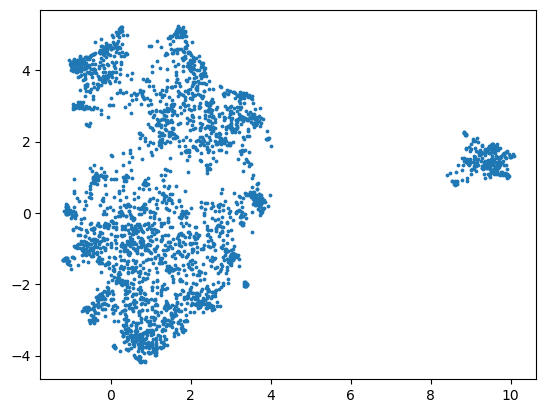

In [54]:
# plot embedding
plt.scatter(embedding[:, 0], embedding[:, 1], s=3, cmap='Spectral')
plt.show()

In [55]:
#write embedding to csv file with header x,y
np.savetxt("../data/simonw-umap.csv", embedding, delimiter=",", header="x,y", comments='')

In [56]:
# Create an HDBSCAN instance with custom parameters
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)



In [57]:
# Fit the model to your dataset
clusterer.fit(embedding)

HDBSCAN(min_samples=5)

In [58]:
np.unique(clusterer.labels_)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115])

In [59]:
# write clusterer.labels_ to a csv file
np.savetxt("../data/simonw-hdbscan.csv", clusterer.labels_, delimiter=",", header="cluster", comments="")

In [66]:
# select all of the blog entries in the same order as the blog_entry_embeddings table
data = run_query("SELECT id,title,slug,body,created FROM blog_entry where id in (select id from blog_entry_embeddings) ORDER BY id ASC ")

In [67]:
data.shape

(2940, 5)

In [68]:
# add the cluster labels to the dataframe
data['cluster'] = clusterer.labels_

In [69]:
# add x and y as columns to the dataframe from the embedding
data['x'] = embedding[:, 0]
data['y'] = embedding[:, 1]

In [70]:
data.head()

,id,title,slug,body,created,cluster,x,y
0,1,WaSP Phase II,webStandards,"<p>The <a href=""http://www.webstandards.org/"">...",2002-06-12T01:44:12+00:00,97,0.776320,-2.716431
1,2,Blogging aint easy,bloggingAintEasy,<p>Blogging isn't nearly as easy as it looks. ...,2002-06-12T02:02:41+00:00,-1,-0.616142,-0.487345
2,3,Todo list,todoList,<h4>Weblog TODO List</h4>\nI've got the bare b...,2002-06-12T02:47:03+00:00,102,-0.605699,-1.007559
3,4,Netscape 4 is 5 years old,t1024344375,<p>Netscape 4 hit 5 years old yesterday. Scott...,2002-06-12T02:59:49+00:00,79,-0.214446,-2.314377
4,5,Webdesign-L ablaze!,t1024344376,"<p>The <a href=""http://www.webdesign-l.com/"" t...",2002-06-12T14:29:41+00:00,97,0.702625,-2.764652


In [71]:
# write the dataframe to a csv file
data.to_csv("../data/simonw-db.csv", index=False)

In [72]:
# group by cluster and concat the titles
cluster_extract = data.groupby('cluster')['title'].apply(lambda x: '\n*'.join(x)).reset_index()

In [73]:
# rename the title column of cluster_titles to summary
cluster_extract.rename(columns={'title': 'extract'}, inplace=True)

In [74]:
# save the cluster titles to a csv file
cluster_extract.to_csv('../data/simonw-cluster-extract.csv', index=False)